# Constructive Vector Fields for Path Following in Matrix Lie Groups
## A Tutorial for SE(3)

---

This script provides an intuitive, step-by-step example of how to use our strategy within the group SE(3). We chose Python here for clarity and accessibility, although this implementation may run slower than our original C++ version.

# Library Installation

This script uses the following libraries: `scipy`, `numpy`, and `plotly`. The next cell will install these libraries if they aren't already installed.

In [1]:
import importlib
import sys

# Function to check and install packages
def install_if_needed(package):
    try:
        importlib.import_module(package)
        print(f'{package} is already installed')
    except ImportError:
        !{sys.executable} -m pip install --quiet {package}

# Check and install required packages
for package in ['scipy', 'numpy', 'plotly']:
    install_if_needed(package)

scipy is already installed
numpy is already installed
plotly is already installed


# Curve parametrization $h_d(s)$

## Define Your Curve Here:

As an example, we define the curve used in the paper, based on the hyperbolic paraboloid. The notation matches that in the paper for consistency.

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

> **Note**: Ensure your function always includes `s` as its first parameter.

In [1]:
import numpy as np
def hd(s, r=1, b=1, d=0.2):
    """Curve parametrization used in paper. This is based on the hyperbolic 
    paraboloid.

    Parameters
    ----------
    s : float
        Parameter of the curve. It must be in the interval [0, 1].
    r : float, optional
        Radius of the curve in XY plane. The default is 1.
    b : float, optional
        Height of the curve. The default is 1.
    d : float, optional
        Curvature of the curve. The default is 0.2.
    
    Returns
    -------
    hds : np.array
        Homogeneous transformation matrix of the curve evaluated at parameter s.
        This is a 'list' of elements of the SE(3) group.
    """
    theta = 2 * np.pi * s
    hds = np.identity(4) # initialize the homogeneous transformation matrix
    position = [r * np.cos(theta), r * np.sin(theta), b + d * r**2 * (np.cos(theta)**2 - np.sin(theta)**2)]
    hds[:3, 3] = np.array(position)
    orientation = np.array([[1, 0, 0], [0, np.cos(theta), np.sin(theta)], [0, -np.sin(theta), np.cos(theta)]])
    hds[:3, :3] = orientation
    return hds

## Precompute the curve

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

This cell defines a function to precompute the curve for each parameter `s`. It assumes the curve is given by a function `hd` that takes `s` as input and returns the corresponding homogeneous transformation matrix (with possible optional arguments). Make sure `hd` is defined as described above. The number of points in the precomputed curve is defined by `n_points`

In [2]:
def precomputed_hd(n_points, *args, **kwargs):
    """Function that precomputes the curve for each parameter s.

    Parameters
    ----------
    n_points : int
        Number of points in the curve.
    *args : list
        Arguments of the curve function.
    **kwargs : dict
        Keyword arguments of the curve function.
    
    Returns
    -------
    precomputed : np.array
        Array with the precomputed curve. The shape is (n_points, 4, 4).
    """
    s = np.linspace(0, 1, num=n_points)
    precomputed = []
    for si in s:
        precomputed.append(hd(si, *args, **kwargs))
    precomputed = np.array(precomputed)
    return precomputed

### Example of how to use the curve-related functions

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

In this section, we define our curve using the `precomputed_hd` function. Adjust the number of points along the curve and specify the curve parameters as needed.

In [3]:
n_points = 5000
r = 1
b = 1
d = 0.2
curve = precomputed_hd(n_points, r, b, d)
print(curve[:3])

[[[ 1.          0.          0.          1.        ]
  [ 0.          1.          0.          0.        ]
  [ 0.         -0.          1.          1.2       ]
  [ 0.          0.          0.          1.        ]]

 [[ 1.          0.          0.          0.99999921]
  [ 0.          0.99999921  0.00125689  0.00125689]
  [ 0.         -0.00125689  0.99999921  1.19999937]
  [ 0.          0.          0.          1.        ]]

 [[ 1.          0.          0.          0.99999684]
  [ 0.          0.99999684  0.00251377  0.00251377]
  [ 0.         -0.00251377  0.99999684  1.19999747]
  [ 0.          0.          0.          1.        ]]]


# EE-distance ($\widehat{D}$)

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

This section defines the $\widehat{D}$ function (EE-distance).

> **Note**: This is a straightforward algorithm to compute  $\|\log(V^{-1} W)\|_F$ (see section 4.1).

> **Note**: We use the inverse of the rotation matrix instead of the transpose, as it is more numerically stable.

In [4]:
def D_hat(V, W):
    """The Element-Element (EE-)distance function. This uses the algorithm in
    section 4.1 of the paper, and is an evaluation of ||log(V^-1 W)||_F.

    Parameters
    ----------
    V : np.array
        Homogeneous transformation matrix V (SE(3) element).
    W : np.array
        Homogeneous transformation matrix W (SE(3) element).
    
    Returns
    -------
    distance : float
        The EE-distance between V and W.
    """
    # Compute Z = V^-1 W
    Z = np.linalg.inv(V) @ W
    # Extract the rotation matrix
    Q = Z[:3, :3]
    # Extract the translation vector
    t = Z[:3, 3]
    # Compute the auxiliary variables
    u = 0.5 * (np.trace(Q) - 1) # This is cos(theta)
    v = 1/(2*np.sqrt(2)) * np.linalg.norm(Q - np.linalg.inv(Q), ord='fro') # This is sin(theta)
    # Compute theta with atan2
    theta = np.arctan2(v, u)
    # Recompute cos and theta to ensure correct values
    u = np.cos(theta)
    v = np.sin(theta)
    # Compute alpha
    alpha = (2 - 2*u - theta**2) / (4*(1 - u)**2)
    # Compute matrix M
    M = np.eye(3) * (1 - 2*alpha) + (Q + np.linalg.inv(Q)) * alpha
    # Compute the EE-distance
    distance = np.sqrt(2 * theta**2 + (t.T @ M @ t))
    return distance

# EC-distance $D$

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

This section defines the $D$ function (EC-distance). We use a brute-force approach to calculate it:

In [5]:
def D(V, curve_parametrization):
    """The Element-Curve (EC-)distance function. This uses the brute force
    approach to compute the minimum distance between V and the curve
    parametrization hd(s). (See Definition 3.4 in paper). This function
    also returns the index of the curve that is closest to V for simplicity.

    Parameters
    ----------
    V : np.array
        Homogeneous transformation matrix V (SE(3) element).
    curve_parametrization : np.array
        Array with the precomputed curve. The shape is (n_points, 4, 4).
    
    Returns
    -------
    min_distance : float
        The minimum distance between V and the curve.
    min_index : int
        The index of the curve that is closest to V.
    """
    min_distance = np.inf
    min_index = -1
    for i, Hd_s in enumerate(curve_parametrization):
        distance = D_hat(V, Hd_s)
        if distance < min_distance:
            min_distance = distance
            min_index = i
    return min_distance, min_index

# $\mathcal{S}$ and $\mathcal{S}^{-1}$ map

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

In this section, we define the $\mathcal{S}$ map based on the basis described in the paper (section 4.3). This map converts a classical twist vector into a Lie algebra element. You can change the basis to observe the differences in the results, but make sure to also update the inverse function `S_inv`.

In [6]:
def S(xi):
    """S map in paper (See Definition 2.2). In this case we assume the basis
    as in section 4.3, since it will render the classical twist vector. This
    maps a vector xi into the Lie algebra se(3).

    Parameters
    ----------
    xi : np.array
        Twist vector xi.
    
    Returns
    -------
    lie_algebra : np.array
        The corresponding Lie algebra element.
    """
    xi = np.array(xi).ravel()
    lie_algebra = np.zeros((4, 4)) # Initialize the Lie algebra element
    # The last three elements of xi are assigned to the upper right 3x3 block
    lie_algebra[0, 1] = -xi[5]
    lie_algebra[0, 2] = xi[4]
    lie_algebra[1, 2] = -xi[3]
    # Since the orientation-related portion of the lie algebra is skew-symmetric,
    # we can compute it as (since the position-related portion is still zero):
    lie_algebra = lie_algebra - lie_algebra.T

    # The first three elements of xi are assigned to the last column
    lie_algebra[:3, 3] = xi[:3]
    return lie_algebra

def S_inv(lie_algebra):
    """The inverse of the S map. This maps a Lie algebra element to the twist
    vector. Here we also assume the basis as in section 4.3.

    Parameters
    ----------
    lie_algebra : np.array
        The Lie algebra element.
    
    Returns
    -------
    xi : np.array
        The corresponding twist vector xi.
    """
    xi = np.zeros(6) # Initialize the twist vector
    # The last three elements of xi are assigned from the upper right 3x3 block
    xi[3] = -lie_algebra[1, 2]
    xi[4] = lie_algebra[0, 2]
    xi[5] = -lie_algebra[0, 1]
    # The first three elements of xi are assigned from the last column
    xi[:3] = lie_algebra[:3, 3]
    return (xi).reshape(-1, 1)

# $\text{L}$ operator

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

This section defines the $\text{L}$ operator, which serves as our 'derivative' in the paper (see Definition 2.6). We assume that the function takes two arguments: $V$ and $W$.

In [7]:
from scipy.linalg import expm # this is the matrix exponential

def L(f, V, W, arg='V', epsilon=1e-3):
    """L operator (see Definition 2.6). This is a 'derivative' in the Lie group.
    Note that this is a portion of the Lie derivative.

    Parameters
    ----------
    f : function
        Differentiable function that receives two arguments, V and W. This
        function maps SE(3) x SE(3) -> R.
    V : np.array
        Homogeneous transformation matrix V (SE(3) element).
    W : np.array
        Homogeneous transformation matrix W (SE(3) element).
    arg : str or int, optional
        The argument to compute the derivative. The default is 'V'. The options
        are 'V' (0) or 'W' (1). If 'V' is selected, the derivative is computed
        with respect to V, and if 'W' is selected, the derivative is computed
        with respect to W.
    epsilon : float, optional
        Small value to compute the derivative. The default is 1e-3.
    
    Returns
    -------
    L_ : np.array
        The resulting L operator. This is a row vector of shape (1, 6).

    Raises
    ------
    ValueError
        If an invalid argument 'arg' is passed.
    """
    L_ = np.zeros((1, 6)) # Initialize the resulting L
    I = np.eye(6) # Initialize the identity matrix
    if arg.lower() == 'v' or arg == 0:
        curr_f = f(V, W)
        for j in range(6):
            zeta = I[:, j]
            next_f_j = f(expm(S(zeta) * epsilon) @ V, W)
            L_[0, j] = (next_f_j - curr_f) / epsilon
    elif arg.lower() == 'w' or arg == 1:
        curr_f = f(V, W)
        for j in range(6):
            zeta = I[:, j]
            next_f_j = f(V, expm(S(zeta) * epsilon) @ W)
            L_[0, j] = (next_f_j - curr_f) / epsilon
    else:
        raise ValueError("Invalid argument 'arg'. Use 'V' (0) or 'W' (1).")
    return L_

# $\Xi$ operator

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

This implementation takes advantage of the fact that the curve is already discretized.

In [8]:
def XI(curve_parametrization, i, ds=0.01):
    """XI operator (See Definition 2.5). This function returns the necessary 
    twist in order to move from the i-th point to the (i+1)-th point in the 
    curve. This is an approximation of the 'derivative' of the curve. Parameter
    'i' will be used as the index of the nearest point in the curve throughout
    the script.

    Parameters
    ----------
    curve_parametrization : np.array
        Array with the precomputed curve. The shape is (n_points, 4, 4).
    i : int
        Index of the point in the curve.
    ds : float, optional
        Small value to compute the variation. The default is 0.01.
    
    Returns
    -------
    XI_ : np.array
        The corresponding twist vector xi.
    """
    # get G
    G = curve_parametrization[i]
    # If the index is the last, then the next point is the first in the curve.
    # Otherwise, the next point is the next in the curve
    if i == len(curve_parametrization) - 1:
        G_next = curve_parametrization[0]
    else:
        G_next = curve_parametrization[i + 1]
    # Compute the 'derivative'
    dGdsigma = (G_next - G) / ds
    XI_ = S_inv(dGdsigma @ np.linalg.inv(G))
    return XI_

# Gains $k_N(D)$ and $k_T(D)$

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

In this section, we use the same gains as described in section 4.4.

> **Note**: If you create your own functions, the `distance` **MUST** be the first argument. You can add any other constant arguments to the functions as needed.

In [9]:
def k_N(distance, internal_gain=20):
    """The gain of the normal component (k_N). This is a function of the minimum
    distance between the system and the curve. This is the same function as in
    section 4.4 of the paper.

    Parameters
    ----------
    distance : float
        Minimum distance between the system and the curve.
    internal_gain : float, optional
        Internal gain of the function. The default is 20.
    
    Returns
    -------
    float
        The gain of the normal component.
    """
    return np.tanh(internal_gain * distance)

def k_T(distance, internal_gain=0.5):
    """The gain of the tangent component (k_T). This is a function of the minimum
    distance between the system and the curve. This is the same function as in
    section 4.4 of the paper.

    Parameters
    ----------
    distance : float
        Minimum distance between the system and the curve.
    internal_gain : float, optional
        Internal gain of the function. The default is 0.5.
    
    Returns
    -------
    float
        The gain of the tangent component.
    """
    return 1 - internal_gain * np.tanh(distance)

## Create gain functions that only depend on one argument `distance` ($D$)

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

In this section, we utilize a function factory to return gain functions that take only one argument (`distance`). These functions will be used in the remainder of the script.

In [10]:
def gain_factory(gain, *args, **kwargs):
    """Function factory to return the gains with only one argument (distance).
    This is used to simplify the simulation function.

    Parameters
    ----------
    gain : function
        The gain function.
    *args : list
        Arguments of the gain function.
    **kwargs : dict
        Keyword arguments of the gain function.
    
    Returns
    -------
    gain_func : function
        The gain function with only one argument (distance).
    """
    def gain_func(distance):
        return gain(distance, *args, **kwargs)
    return gain_func

# Simulation Function

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

In this section, we define a function to simulate the system in $\text{SE}(3)$ along with an auxiliary function to display a progress bar.


In [11]:
import sys
def progress_bar(i, imax):
    """Prints a progress bar in the terminal.

    Parameters
    ----------
    i : int
        Current iteration.
    imax : int
        Maximum number of iterations.
    """
    sys.stdout.write("\r")
    sys.stdout.write(
        "[%-20s] %d%%" % ("=" * round(20 * i / (imax - 1)), round(100 * i / (imax - 1)))
    )
    sys.stdout.flush()
    
# Function to simulate the system:
def simulate(H0, k_N, k_T, T=20, dt=0.01, ds=None):
    """Simulate the system. This function uses the gains k_N and k_T, and the
    curve defined in the script. The function returns the history of the system
    states, the history of the minimum distances, the history of the nearest
    points in the curve, and the history of the vector fields.

    Parameters
    ----------
    H0 : np.array
        Initial homogeneous transformation matrix of the system (SE(3) element).
    k_N : function
        Gain function of the normal component. This function must receive only
        the distance as argument.
    k_T : function
        Gain function of the tangent component. This function must receive only
        the distance as argument.
    T : float, optional
        Total simulation time. The default is 20.
    dt : float, optional
        Time step of the simulation. The default is 0.01.
    ds : float, optional
        Small value to compute the curve 'derivative'. The default is None. If
        None, the value is 1 / len(curve).
    
    Returns
    -------
    H_hist : list
        History of the system states.
    distance_hist : list
        History of the minimum distances.
    nearest_point_hist : list
        History of the nearest points in the curve.
    vector_field_hist : list
        History of the vector fields.
    """
    # Initialize the variables
    H = H0
    imax = int(T/dt)
    if ds is None:
        ds = 1 / len(curve)
    H_hist = []
    distance_hist = []
    nearest_point_hist = []
    vector_field_hist = []
    for i in range(imax):
        progress_bar(i, imax)
        # Compute the minimum distance and the nearest index:
        min_distance, min_index = D(H, curve)
        # Compute the nearest point:
        Hd_star = curve[min_index]
        # Compute the normal component:
        xi_N = -L(D_hat, H, Hd_star, 'V').T
        # Compute the tangent component:
        xi_T = XI(curve, min_index, ds=ds)
        # Compute the vector field:
        psi = k_N(min_distance) * xi_N + k_T(min_distance) * xi_T
        # Update the system
        H = expm(S(psi) * dt) @ H
        # Save the variables
        H_hist.append(H)
        distance_hist.append(min_distance)
        nearest_point_hist.append(Hd_star)
        vector_field_hist.append(psi)
    return H_hist, distance_hist, nearest_point_hist, vector_field_hist

# System Simulation

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

In this section, we set the parameters and simulate the system. We also redefine the curve for simplicity.

In [12]:
# Define parameters for the simulation

# Pass your gain functions here with your defined arguments (except for the distance argument).
# This will convert the functions to the required format, which only takes one argument (distance).
k_N_ = gain_factory(k_N, internal_gain=20)
k_T_ = gain_factory(k_T, internal_gain=0.5)

# Define the initial condition
H0 = np.array([[np.cos(np.deg2rad(45)), -np.sin(np.deg2rad(45)), 0, -2], 
               [np.cos(np.deg2rad(45)), np.sin(np.deg2rad(45)), 0, -1], 
               [0, 0, 1, 0], 
               [0, 0, 0, 1]])

# Redefine the curve for practical reasons
n_points, r, b, d = 5000, 1, 1, 0.2
curve = precomputed_hd(n_points, r, b, d) # Precomputed curve

T = 8 # Simulation time in seconds, (actually 15 in the paper)
dt = 0.01 # Time step
ds = 0.001 # Small value to compute the curve's 'derivative'

# Simulate the system and store the results
H_hist, distance_hist, nearest_point_hist, vector_field_hist = simulate(H0, k_N_, k_T_, T, dt, ds)

[====================] 100%

# Plot the results

We will use Plotly to visualize the distance function (along with more intuitive representations of position and orientation errors) and the system trajectory, as shown in the paper.

## Distance plot:

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

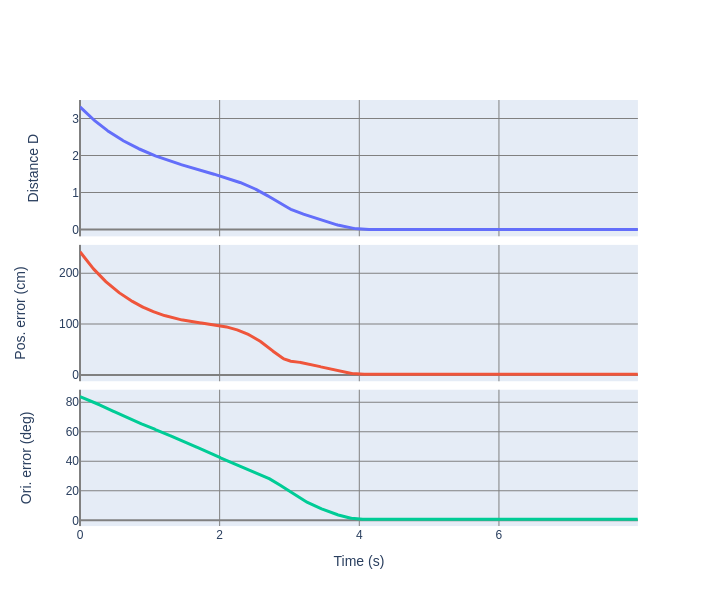

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

closest_points = nearest_point_hist
states = H_hist
distances = distance_hist

ori_errs = []
pos_errs = []
# Compute the distance, position error, and orientation error
for closest_point, state in zip(closest_points, states):
    p_near = closest_point[:3, 3]
    ori_near = closest_point[:3, :3]
    p_curr = state[:3, 3]
    ori_curr = state[:3, :3]
    pos_errs.append(np.linalg.norm(p_near - p_curr) * 100)
    trace_ = np.trace(ori_near @ np.linalg.inv(ori_curr))
    acos = np.arccos((trace_ - 1) / 2)
    # checks if acos is nan
    if np.isnan(acos):
        acos = 0
    ori_errs.append(acos * 180 / np.pi)

# Create a figure with three plots, one above another. First the distance, 
# then position error, and the orientation error
time_vec = np.arange(0, len(pos_errs) * dt, dt)
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=time_vec, y=distances, showlegend=False, line=dict(width=3)), row=1, col=1)
fig.add_trace(go.Scatter(x=time_vec, y=pos_errs, showlegend=False, line=dict(width=3)), row=2, col=1)
fig.add_trace(go.Scatter(x=time_vec, y=ori_errs, showlegend=False, line=dict(width=3)), row=3, col=1)
fig.update_xaxes(title_text="Time (s)", gridcolor='gray', zerolinecolor='gray', row=3, col=1)
fig.update_xaxes(title_text="", gridcolor='gray', zerolinecolor='gray', row=1, col=1)
fig.update_xaxes(title_text="", gridcolor='gray', zerolinecolor='gray', row=2, col=1)
fig.update_yaxes(title_text="Distance D", gridcolor='gray', zerolinecolor='gray', 
                 row=1, col=1, title_standoff=30)
fig.update_yaxes(title_text="Pos. error (cm)", gridcolor='gray', zerolinecolor='gray', 
                 row=2, col=1, title_standoff=30)
fig.update_yaxes(title_text="Ori. error (deg)", gridcolor='gray', zerolinecolor='gray', 
                 row=3, col=1, title_standoff=30)

fig.update_layout(width=718.110, height=605.9155)
fig.show()

## Trajectory plot function

<div style="background-color: #282c34; color: #e06c75; padding: 10px; border-radius: 5px;">
❌ <b>Warning:</b> Do not modify the code in the following cell.
</div>

Run the following cell to define the plotting function. The plot will be generated in the next cell.

In [14]:
import plotly.colors as pc
import plotly.graph_objects as go

def vector_field_plot(
    coordinates,
    field_values,
    orientations,
    curve,
    num_arrows=10,
    init_ball=0,
    final_ball=None,
    num_balls=10,
    add_lineplot=False,
    colorscale=None,
    show_curve=True,
    ball_size=5,
    curve_width=2,
    path_width=5,
    frame_scale=0.05,
    frame_width=2,
    curr_path_style="solid",
    prev_path_style="dash",
    **kwargs
):
    """Plot a vector field in 3D. The vectors are represented as cones and the
    auxiliary lineplot is used to represent arrow tails. The kwargs are passed
    to the go.Cone function. Also plots the target curve, and the path of the
    object. The object is represented as a sphere. The orientations are represented
    as frames with the x, y and z axis of the frame.

    Parameters
    ----------
    coordinates : list or np.array
        Mx3 array of coordinates of the vectors. Each row corresponds to x,y,z
        respectively. The column entries are the respective coordinates.
    field_values : list or np.array
        Mx3 array of field values of the vectors. Each row corresponds to u,v,w
        respectively, i.e. the LINEAR velocity of the field in each direction.
        The column entries are the respective values.
    orientations : list or np.array
        Mx3x3 array of orientations of the object. Each row corresponds to the
        orientation of the object at that point. The 'column' entries are the
        respective 3x3 rotation matrices.
    curve : np.array
        Nx3 array of the curve points. Each row corresponds to x,y,z respectively.
    num_arrows : int, optional
        Number of vector field arrows (cones) to plot. The default is 10.
    init_ball : int, optional
        Initial ball index to plot. The default is 0.
    final_ball : int, optional
        Final ball index to plot. The default is None, which plots until the end.
    num_balls : int, optional
        Number of balls to plot. The default is 10.
    add_lineplot : bool, optional
        Whether to add a lineplot of the field coordinates. The default is False.
        This is used to connect the vector field arrows.
    colorscale : list, optional
        List of colors to use in the plot. The default is None, which uses the
        Plotly default colors. The list must have at least 6 colors, which are
        used for the curve, previous path, current path, initial ball, final ball
        and the object, respectively.
    show_curve : bool, optional
        Whether to show the target curve. The default is True.
    ball_size : int, optional
        Size of the object balls. The default is 5.
    curve_width : int, optional
        Width of the curve line. The default is 2.
    path_width : int, optional
        Width of the path line. The default is 5.
    frame_scale : float or list, optional
        Scale factor for the orientation frames. The default is 0.05. If a list
        is given, the scale factor is applied to each axis of the frame.
    frame_width : int, optional
        Width of the orientation frame lines. The default is 2.
    curr_path_style : str, optional
        Style of the current path line. The default is "solid".
    prev_path_style : str, optional
        Style of the previous path line. The default is "dash".
    **kwargs
        Additional keyword arguments to pass to the go.Cone function.

    Returns
    -------
    fig : plotly.graph_objects.Figure
        Resulting plotly figure.
    """
    if final_ball is None:
        final_ball = len(coordinates) - 1

    if isinstance(frame_scale, (int, float)):
        frame_scale = [frame_scale] * 3

    coordinates = np.array(coordinates).reshape(-1, 3)
    arrows_idx = np.round(np.linspace(0, len(coordinates) - 1, num_arrows)).astype(int)
    coord_field = coordinates[arrows_idx].T
    field_values = np.array(field_values).reshape(-1, 3)[arrows_idx].T
    ball_idx = np.round(np.linspace(init_ball, final_ball, num_balls)).astype(int)
    coord_balls = coordinates[ball_idx]
    ori_balls = np.array(orientations)[ball_idx]
    coordinates = coordinates.T

    if colorscale is None:
        colorscale = pc.qualitative.Plotly

    if isinstance(curve, tuple):
        curve = curve[0]

    fig = go.Figure()

    # Curve
    if show_curve:
        fig.add_trace(
            go.Scatter3d(
                x=curve[:, 0],
                y=curve[:, 1],
                z=curve[:, 2],
                mode="lines",
                line=dict(width=curve_width, color=colorscale[1]),
            )
        )
    # Previous path
    if init_ball > 0:
        fig.add_trace(
            (
                go.Scatter3d(
                    x=coordinates[0, 0:init_ball],
                    y=coordinates[1, 0:init_ball],
                    z=coordinates[2, 0:init_ball],
                    mode="lines",
                    line=dict(width=path_width, dash=prev_path_style, color=colorscale[5]),
                )
            )
        )

    # Current path
    fig.add_trace(
        go.Scatter3d(
            x=coordinates[0, init_ball:final_ball],
            y=coordinates[1, init_ball:final_ball],
            z=coordinates[2, init_ball:final_ball],
            mode="lines",
            line=dict(width=path_width, dash=curr_path_style, color=colorscale[0]),
        )
    )

    # Vector field arrows
    fig.add_trace(
        go.Cone(
            x=coord_field[0, :],
            y=coord_field[1, :],
            z=coord_field[2, :],
            u=field_values[0, :],
            v=field_values[1, :],
            w=field_values[2, :],
            colorscale=[[0, colorscale[5]], [1, colorscale[5]]],  # Set the colorscale
            showscale=False,
            **kwargs,
        )
    )

    # Orientation frames
    if orientations is not None:
        for i, ori in enumerate(ori_balls):
            px, py, pz = coord_balls[i, :]
            ux, uy, uz =  ori[:, 0] / (np.linalg.norm(ori[:, 0] + 1e-6)) * frame_scale
            vx, vy, vz =  ori[:, 1] / (np.linalg.norm(ori[:, 1] + 1e-6)) * frame_scale
            wx, wy, wz =  ori[:, 2] / (np.linalg.norm(ori[:, 2] + 1e-6)) * frame_scale
            fig.add_trace(
                go.Scatter3d(
                    x=[px, px + ux],
                    y=[py, py + uy],
                    z=[pz, pz + uz],
                    mode="lines",
                    line=dict(color="red", width=frame_width),
                )
            )
            fig.add_trace(
                go.Scatter3d(
                    x=[px, px + vx],
                    y=[py, py + vy],
                    z=[pz, pz + vz],
                    mode="lines",
                    line=dict(color="lime", width=frame_width),
                )
            )
            fig.add_trace(
                go.Scatter3d(
                    x=[px, px + wx],
                    y=[py, py + wy],
                    z=[pz, pz + wz],
                    mode="lines",
                    line=dict(color="blue", width=frame_width),
                )
            )

    # Object
    for i, coord in enumerate(coord_balls):
        if i == 0:
            color = colorscale[3]
        elif i == len(coord_balls) - 1:
            color = colorscale[4]
        else:
            color = "rgba(172, 99, 250, 0.6)"
        fig.add_trace(
            go.Scatter3d(
                x=[coord[0]],
                y=[coord[1]],
                z=[coord[2]],
                mode="markers",
                marker=dict(size=ball_size, color=color),
            )
        )

    if add_lineplot:
        fig.add_scatter3d(
            x=coordinates[0, :], y=coordinates[1, :], z=coordinates[2, :], mode="lines"
        )

    return fig

## Trajectory plot

<div style="background-color: #282c34; color: #98c329; padding: 10px; border-radius: 5px;">
⚠️ <b>Editable Section:</b> Feel free to modify the cell below.
</div>

> **NOTE:** Many of the defined parameters are for the aesthetics of the Plotly figure.

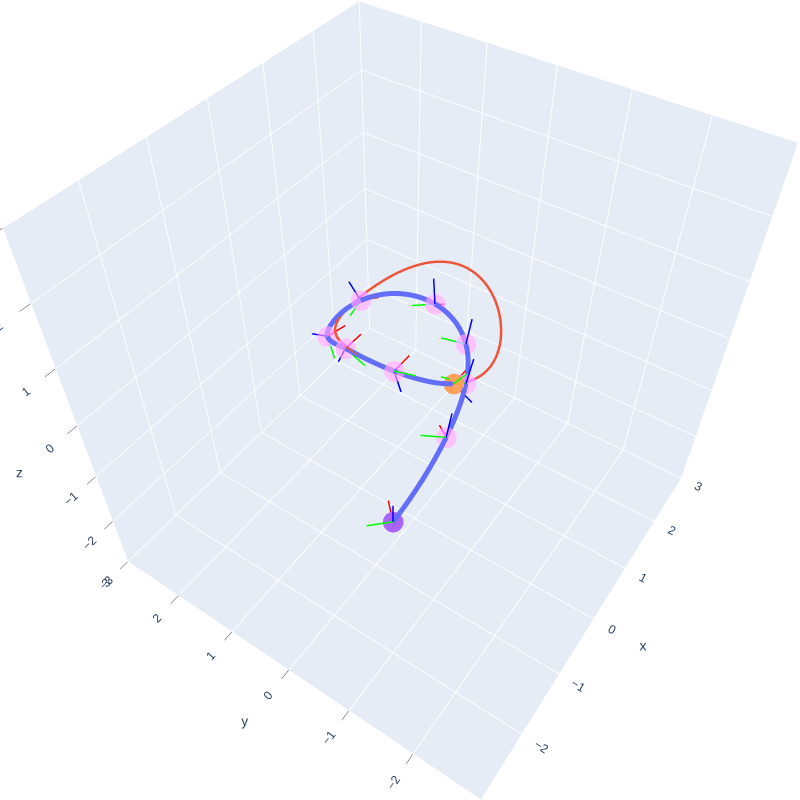

In [ ]:
# Convert the lists to numpy arrays as expected by the function
coordinates = np.array([H[:3, 3] for H in H_hist])
orientations = np.array([H[:3, :3] for H in H_hist])
field_values = np.array([vf[:3, 0] for vf in vector_field_hist])
curve_positions = np.array([c[:3, 3] for c in curve])

# Define the first and last ball to plot (the first and last states)
final_ball = 499 # 499 for 1st, 970 for 2nd, 1450 for 3rd
init_ball = 0  # 0 for 1st, 499 for 2nd, 970 for 3rd

# Define the ticks for the plot
xticks = [-3, 3]
yticks = [-3, 3]
zticks = [-3, 3]

# Adjusts the size of each line of the frame representation
frame_scale = [abs(xticks[1] - xticks[0]), abs(yticks[1] - yticks[0]), abs(zticks[1] - zticks[0])]
frame_scale = .3 * 1/(np.max(frame_scale) / frame_scale)

# Create the figure
fig = vector_field_plot(coordinates, field_values, orientations, curve_positions, 
                        init_ball=init_ball, final_ball=final_ball, 
                        curr_path_style="solid", prev_path_style="dash", 
                        ball_size=12, curve_width=5, path_width=10, 
                        frame_scale=frame_scale, frame_width=3,
                        sizemode="absolute", sizeref=3e-2, anchor="tail",)

# Figure layout parameters
eye = {'x': -1.1895395264042192, 'y': -0.7763234687127192,'z': 1.4869053271198966}
center = {'x': 0.03903242065155699, 'y': 0.07130795959536744, 'z': -0.13962461747321292}
camera = dict(eye=eye, center=center, up=dict(x=0, y=0, z=1))
args = dict(
    margin=dict(t=0, b=0, r=0, l=0, pad=0),
    scene_camera=camera,
    showlegend=False,
    scene_aspectmode="cube",
    scene_yaxis=dict(
        range=yticks,
        ticks="outside",
    ),
    scene_zaxis=dict(
        range=zticks,
        ticks="outside",
    ),
    scene_xaxis=dict(
        range=xticks,
    ),
    width=800,
    height=800,
)
fig.update_layout(**args)

# Show the figure
fig.show()